# [Part 2] - Image Classification

## Introduction: Image Classification

The second part of project concerns about Image Classification type of problem. We will be feeding the images with labels being __left, right, and supine__. 

Later we will analyze the model results by generating the classification report and confusion matrix with the help of `scikit-learn` library.

I have included a *Dense* layer inside of the model architecture just before the last layer to get some sort of *encodings*.

Moreover, we will see how these encodings correspond to the distribution of images in 2D by reducing its dimension with the help of Principal Component Analysis.

## Libraries and Frameworks

In [16]:
# Data Load
import os
import itertools
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

import matplotlib.pyplot as plt
%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


## Dataset

I want to split the dataset into three subsets like train, validatio, and test. 

Since I am using `tf.keras.preprocessing.image_dataset_from_directory` function, I am unable to create the third subset out of one directory. That's why, before getting started I want to split the dataset into two parts *(train and test)* and import them as tensorflow datasets, then split the train dataset into two parts like *(train and validation)* with `image_dataset_from_directory` function since it does not write to a disk when it splits the dataset. 

In [2]:
# !split-folders --output '../data/classification_splitted' --ratio 0.9 0.1 -- '../data/classification'


### Generate train and test datasets.

In [57]:
path_classification = '/Users/orkhanbayramli/Desktop/the-last-castle/HDA/project-sleep-posture-monitoring/data/classification_splitted'
image_size = (256, 128)
batch_size = 6

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path_classification, 'train'),
    color_mode='grayscale',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path_classification, 'train'),
    color_mode='grayscale',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path_classification, 'val'),
    color_mode='grayscale',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1849 files belonging to 3 classes.
Using 1480 files for training.
Found 1849 files belonging to 3 classes.
Using 369 files for validation.
Found 205 files belonging to 3 classes.


### Data Augmentation

In [73]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.05, fill_mode='constant'),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.05),
        layers.RandomContrast(0.05)
    ]
)


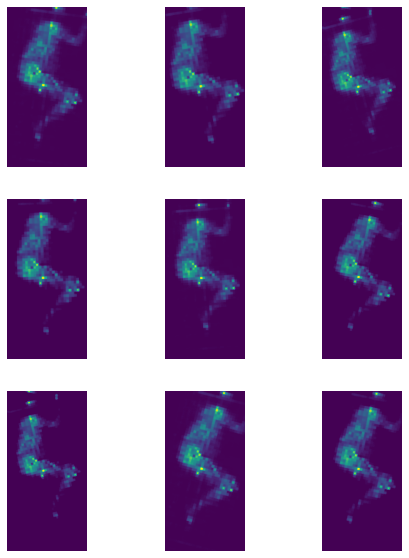

In [74]:
plt.figure(figsize=(8, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        original_image = np.squeeze(images[0])
        augmented_image = augmented_images[0].numpy().astype("uint8")
        augmented_image = np.squeeze(augmented_image, axis=-1)
        plt.imshow(augmented_image)
        plt.axis("off")


## Model

In [7]:
def make_shallow_model(input_shape, num_classes):
    return Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])


def make_cnn_model(input_shape, num_classes):
    return Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])


### Training

1/1 [==============================] - 2s 2s/step - loss: 1.1024 - sparse_categorical_accuracy: 0.1667


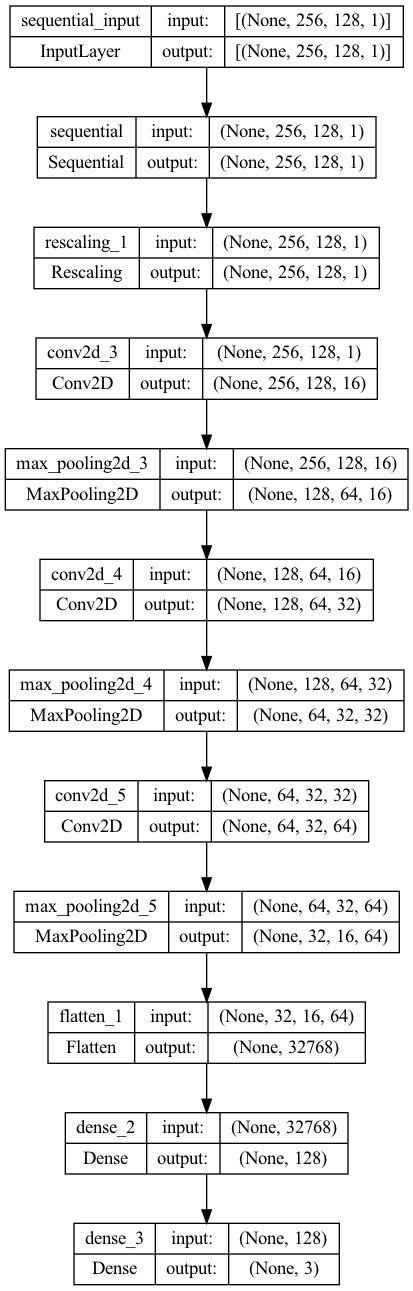

In [42]:
model_type = 'cnn'

if model_type == 'shallow':
    model = make_shallow_model(input_shape=image_size + (1,), num_classes=3)
elif model_type == 'cnn':
    model = make_cnn_model(input_shape=image_size + (1,), num_classes=3)

callbacks = [
    ModelCheckpoint(
        f"../models/{model_type}_image_classification", save_best_only=True),
    TensorBoard(log_dir="../models/logs"),
    EarlyStopping(patience=3),
    ReduceLROnPlateau(patience=2)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# To see the plot we need to build the model first
model.fit(train_ds.take(1))
keras.utils.plot_model(model, show_shapes=True)


In [44]:
epochs = 50
train = False
path_model = '../models/cnn_image_classification'

if train:
    hist = model.fit(
        train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
    )
else:
    model = keras.models.load_model(path_model)


### What CNNs see

In [45]:
input_image = []
for batch in test_ds.take(1):
    images, _ = batch
    input_image = images[0]


In [46]:
intermediate_layers = model.layers[:5]
intermediate_model = Sequential(intermediate_layers)
activations = intermediate_model.predict(np.expand_dims(input_image, axis=0))
activations.shape


1/1 [==============================] - 0s 78ms/step


(1, 128, 64, 32)

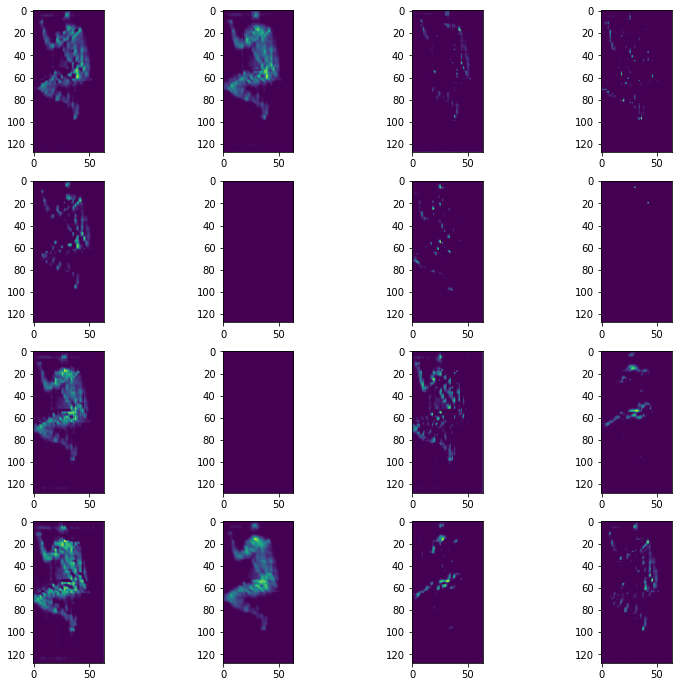

In [47]:
# Viz Grid
num_rows = 4
num_cols = 4

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(13, 12))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    ax[ax_idx[0], ax_idx[1]].imshow(activations[0, :, :, idx])


## Analyzing results

### Inference

Although, the network has been trained on only using the images from experiment 1, it does well also on the samples from the experiment 2. 

1/1 [==============================] - 0s 88ms/step
[[1.0000000e+00 6.8007600e-22 2.9538277e-10]]


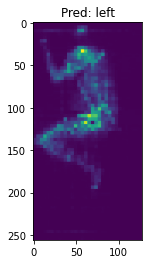

In [48]:
input_image = np.loadtxt(
    "../data/raw/experiment-ii/S1/Sponge_Mat/Matrix_Sponge_B7.txt")
input_image = input_image * 255. / input_image.max()
input_image = input_image.astype('int')
print(input_image.max(), input_image.min())
input_image = np.expand_dims(input_image, axis=-1)


def resize(input_image):
    input_image = tf.image.resize(input_image, image_size,
                                  method=tf.image.ResizeMethod.AREA)
    input_image = tf.image.flip_up_down(input_image)
    return input_image


input_image = resize(input_image)
pred = model.predict(np.expand_dims(input_image, axis=0))
print(pred)
plt.title(f"Pred: {test_ds.class_names[np.argmax(pred)]}")
plt.imshow(np.squeeze(input_image))


### Confusion Matrix and Classification Report

1/1 [==============================] - 0s 25ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       1.00      1.00      1.00        48
           2       0.99      0.99      0.99       109

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



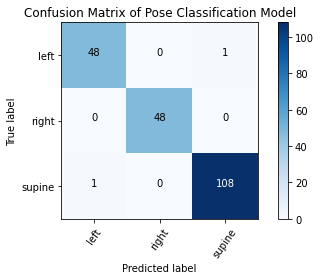

In [49]:
from sklearn.metrics import confusion_matrix, classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis=- 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# Plot the confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)
plot_confusion_matrix(cm,
                      test_ds.class_names,
                      title='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(correct_labels,
                                                          predicted_labels))


# TSNE and K-means

I wanted to test out if there is meaningful clustering between raw pixel values of images. For that sake, I'm using tSNE method for visualizing high-dimensional data by giving each datapoint a location in a two-dimensional map.

## TSNE

In [58]:
imgs_list = []
vis_imgs = []
for images, targets in test_ds.take(30):
    for i in range(6):
        vis_img = tf.keras.preprocessing.image.img_to_array(images[i])
        vis_img = tf.image.resize(vis_img, (64, 32))
        vis_imgs.append(vis_img)
        img_arr = tf.keras.preprocessing.image.img_to_array(images[i])
        imgs_list.append(img_arr.ravel())
img_mat = np.array(imgs_list)
print("Image Mat Shape: ", img_mat.shape)


Image Mat Shape:  (180, 32768)


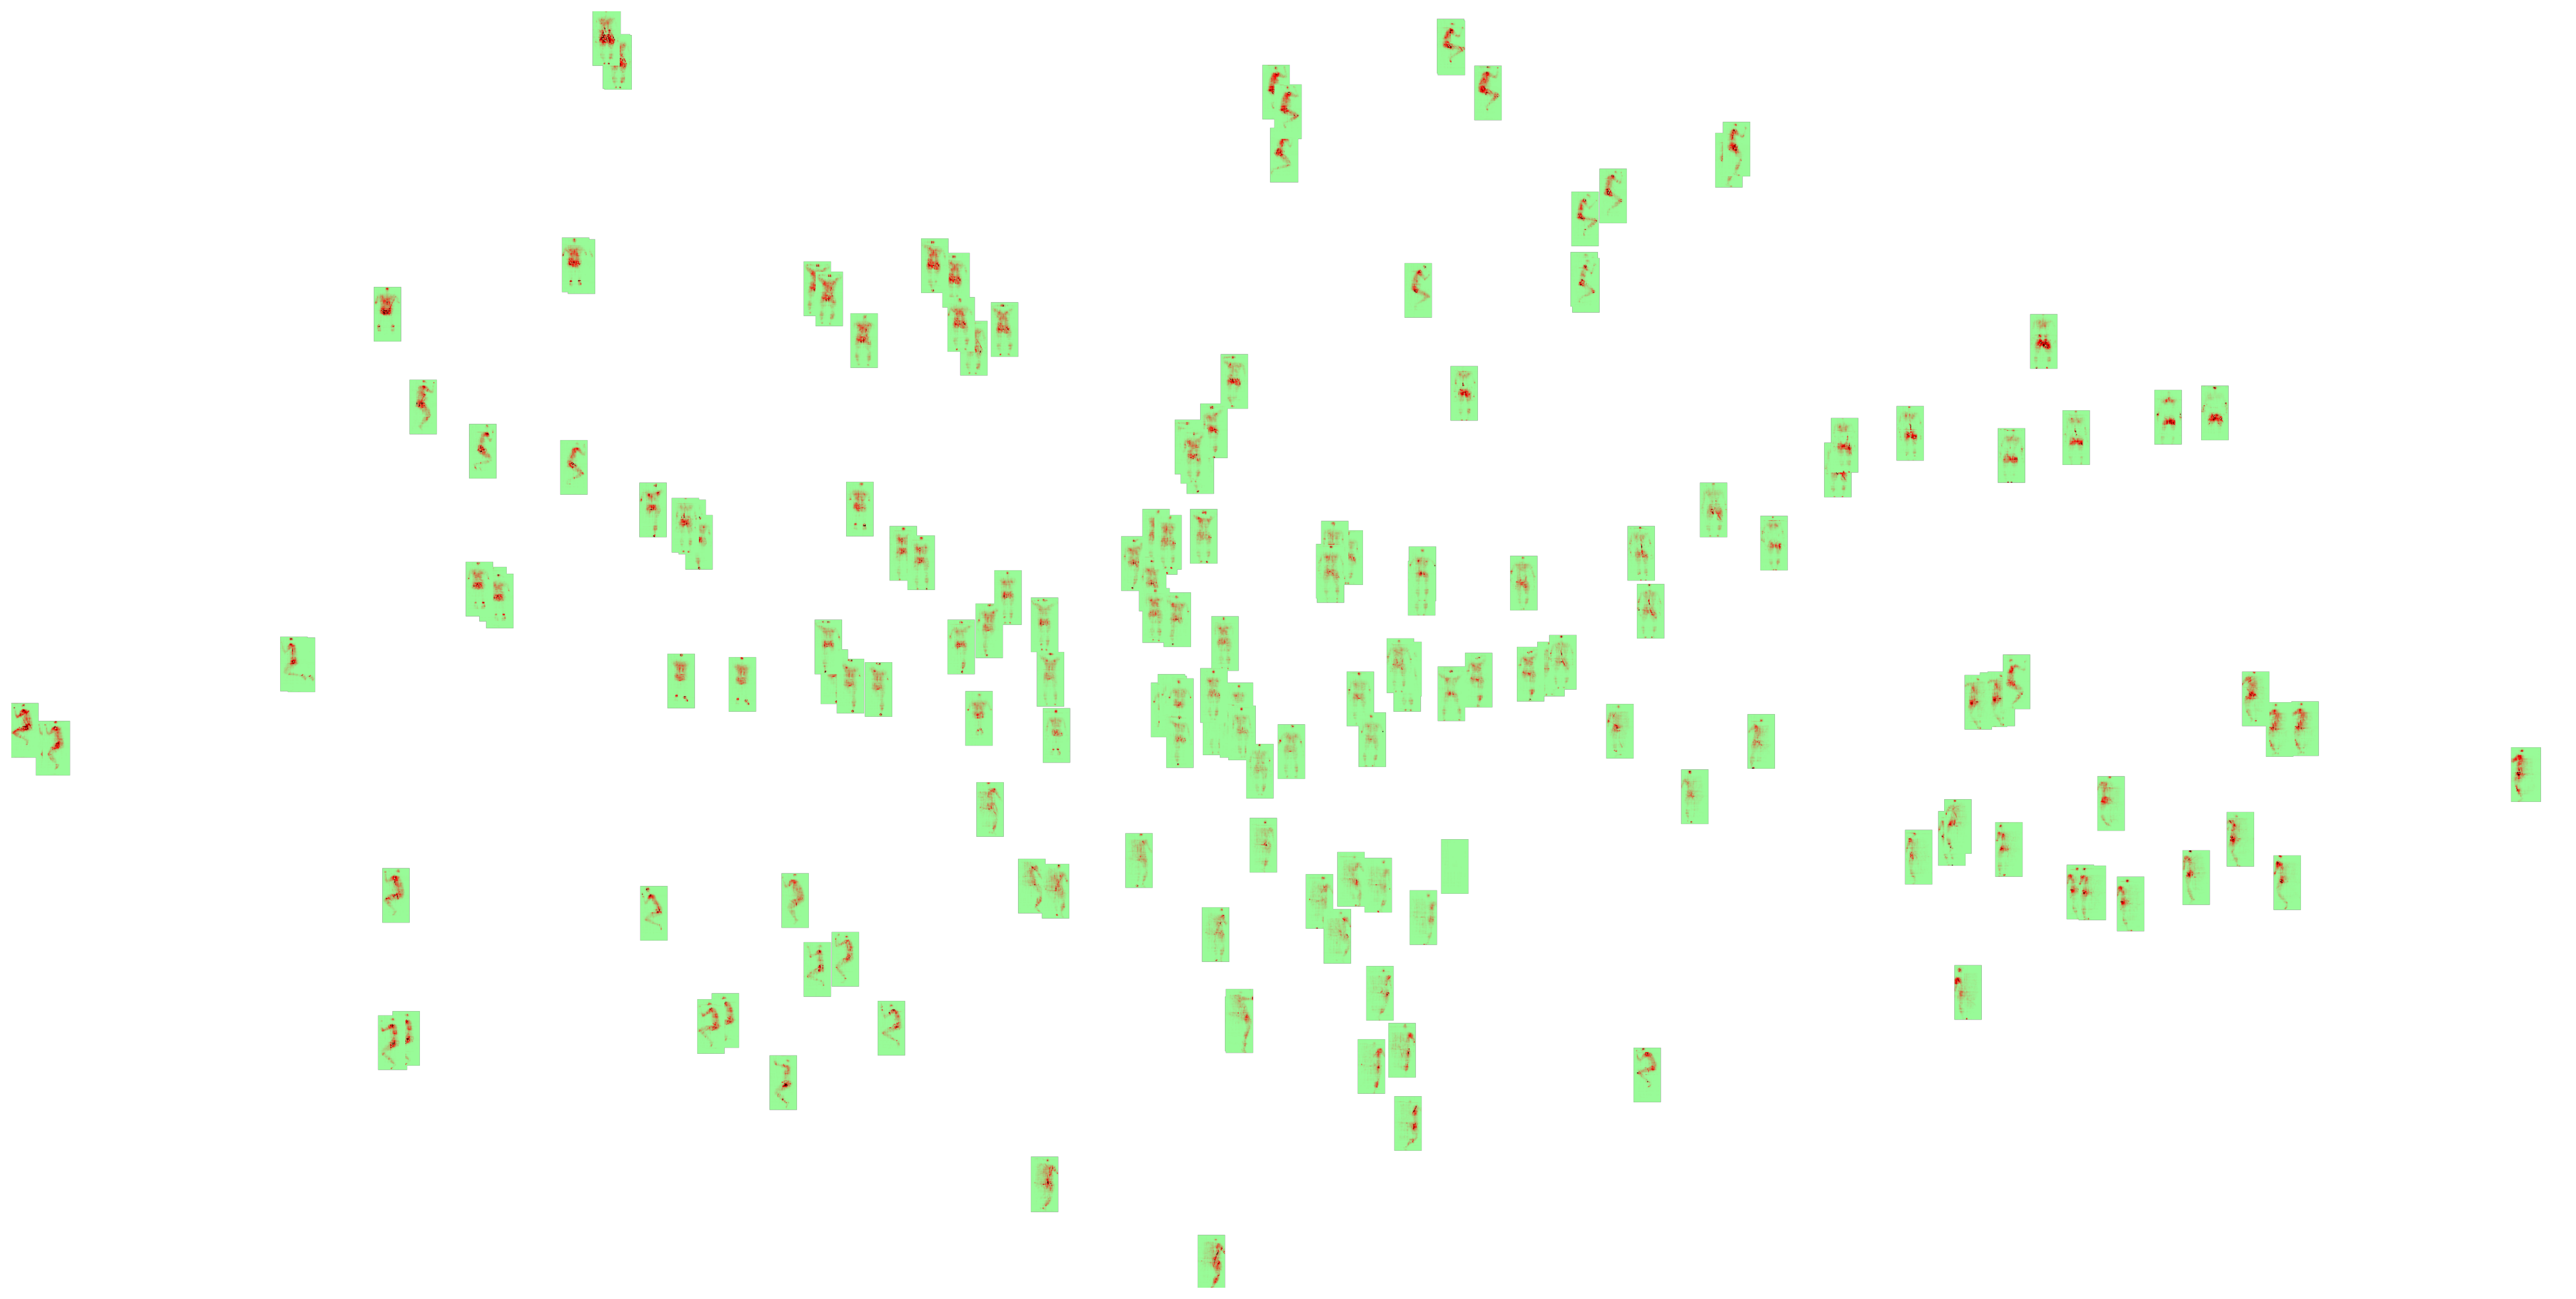

In [71]:
from PIL import Image, ImageOps
from sklearn.manifold import TSNE


def visualize_space(X, images, outfile):

    tsne = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=100).fit_transform(X)
    tx, ty = tsne[:, 0], tsne[:, 1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    width = 3000
    height = 1500

    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(images, tx, ty):
        tile = Image.fromarray(np.squeeze(img).astype('uint8'), mode='L')
        tile = ImageOps.colorize(
            tile, black='palegreen', mid='red', white='black')
        full_image.paste(
            tile, (int((width-60)*x), int((height-60)*y)))

    plt.figure(figsize=(30, 15), dpi=200)
    plt.imshow(full_image)
    plt.axis("off")
    full_image.save(outfile)


visualize_space(img_mat, vis_imgs, "tSNE-PCA-sleep-posture.png")


## K-means

In [78]:
encod_model = Sequential(model.layers[:-2])

encodings = []
for image_batch, _ in val_ds:
    encodings.append(encod_model.predict(image_batch))
encodings = np.concatenate(
    [item for idx, item in enumerate(encodings)], axis=0).astype('double')


1/1 [==============================] - 0s 26ms/step


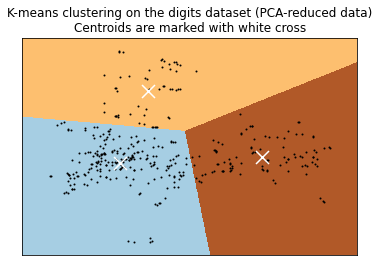

In [79]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encodings)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=20)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the sleep posture dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
